In [1]:
%load_ext pycodestyle_magic
#style enforcer
# install with
#    pip install pycodestyle
#    pip install pycodestyle_magic

In [2]:
# imports
import geopandas as gpd
import pysal as ps
import numpy as np
import sys
import math
import scipy.linalg
import networkx as nx
import random
import matplotlib.pyplot as plt
import csv
import utm
from colormap import rgb2hex
import stateplane

In [20]:
# read in a file for the district-level geography

# my version of the file has a column called 'STATECD'
# which gives a unique identifier to each district
df_cd = gpd.read_file('cd_us.shp')

# choose a state via FIPS code (string)
# '42' is the meaning of life, the universe, and Pennsylvania
# letting state_no = 'all' will do the whole US
state_no = '01'

# add a dummy column to the DataFrame
df_cd['new_field'] = -1

In [4]:
# initialize an empty list to store the new values
new_vals = []

# (somewhat unnecessarily) loop over all rows in the DataFrame
for ind, row in df_cd.iterrows():

    # grab the identifying information
    fcode = row['STATECD']
    st = row['STATEFP']
    fn = fcode[0:2]+'_'+fcode

    # if this row is something we need to compute:
    if st == state_no or state_no == 'all':

        # read in the corresponding district's adjacency matrix
        # [see README in the adj_mats folder for more info]
        adj = np.loadtxt('adj_mats/'+fn+'_dist.txt',
                         delimiter=',')

        # make sure it's an integer matrix
        adj = adj.astype(int)


        # you can build a laplacian matrix
        deg = np.diag(adj.sum(axis=0))
        lap = deg - adj

        # compute something interesting
        # here's the largest eigenvalue of adj
        evals = np.real(scipy.linalg.eigvals(adj).tolist())
        evals.sort()

        # add it to the list
        new_vals.append(evals[-1])

    # if this row isn't something we need to compute
    # put something in the list and keep going
    else:
        new_vals.append(-1)

# put the new values into the DataFrame
df_cd['new_field'] = new_vals


Text(0.5,1,'Largest Eigenvalue')

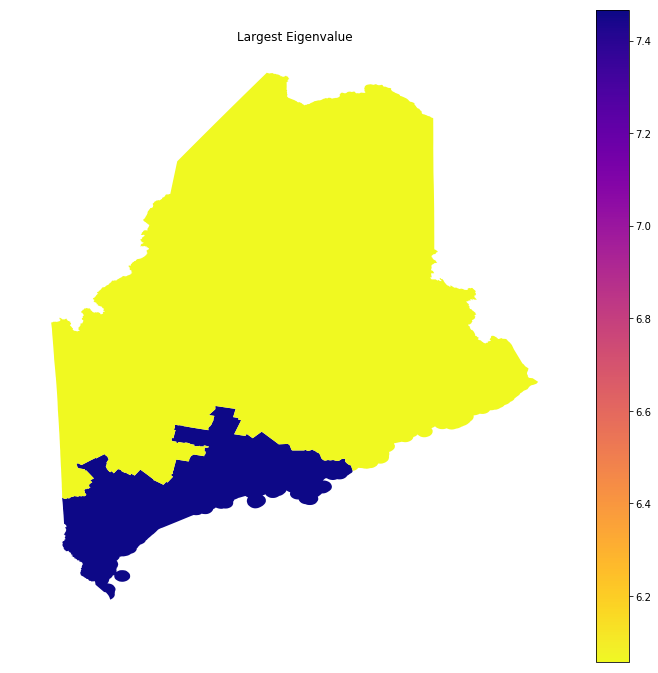

In [5]:
# visualize!

# grab the rows from the dataframe that we need:
if state_no != 'all':
    m = df_cd.loc[df_cd.loc[:, 'STATEFP'] == state_no]
else:
    m = df_cd


# initialize the figure
fig = m.plot(column='new_field',
             legend=True,
             figsize=(12, 12),
             cmap='plasma_r')

# turn off the axes
fig.axis('off')

# give it a name
plt.title('Largest Eigenvalue')

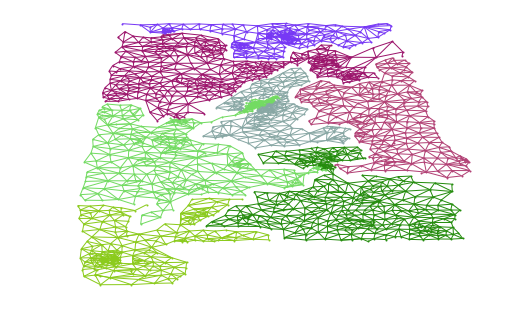

In [33]:
# similar code will let you make networkx graphs
# we'll need to read in spatial indices
# Warning?

_first=True
sp = None

state_no='01'

for ind, row in df_cd.iterrows():

    # grab the identifying information
    fcode = row['STATECD']
    st = row['STATEFP']
    fn = fcode[0:2]+'_'+fcode

    # if this row is something we need to compute:
    if st == state_no or state_no == 'all':

        # read in the corresponding district's adjacency matrix
        # [see README in the adj_mats folder for more info]
        adj = np.loadtxt('adj_mats/'+fn+'_dist.txt',
                         delimiter=',')

        # make sure it's an integer matrix, to be safe
        adj = adj.astype(int)

        # this time, load it into a networkx graph
        gr = nx.from_numpy_matrix(adj)

        # grab (lon,lat) coords from the spatial index
        coords = []
        with open('spatial_indexes/'+fn+'_idx.txt', 'r') as sind:
            reader = csv.reader(sind, delimiter=',')
            for row in reader:
                crd = (float(row[2]),float(row[1]))
                # reproject to utm
                crd = utm.from_latlon(crd[0],crd[1])
                coords.append((crd[0], crd[1]))
                

        # build a dictionary, because for some reason that's how
        # networkx wants coordinates...
        coord_dict = {}
        for n in gr.nodes:
            coord_dict[n] = coords.pop(0)
        # pick a color, any color
        c = rgb2hex(random.randint(0,255), random.randint(0,255), random.randint(0,255))
        nx.draw(gr, coord_dict, node_size=1, node_color=c, edge_color=c)
            